In [2]:
!pip install chromadb openai sentence-transformers streamlit
!pip install python-dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
from tqdm import tqdm

import os
import chromadb
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
import openai
from openai import OpenAI

from google.colab import drive


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to your dataset folder
data_path = "/content/drive/MyDrive/Colab Notebooks/Zaryab Project/Dataset"


In [ ]:
# List files in the directory to verify the upload
json_files = [f for f in os.listdir(data_path) if f.endswith('.json')]
print(f"Total JSON files found: {len(json_files)}")

Total JSON files found: 15011


In [ ]:
# Load a sample JSON file
sample_file = os.path.join(data_path, json_files[0])
with open(sample_file, 'r') as f:
    match_data = json.load(f)

# Display the top-level keys
print(match_data.keys())


dict_keys(['meta', 'info', 'innings'])


In [ ]:
# Print Match Info
print(json.dumps(match_data['info'], indent=4))

{
    "balls_per_over": 6,
    "city": "Colombo",
    "dates": [
        "2024-08-02"
    ],
    "event": {
        "name": "India tour of Sri Lanka",
        "match_number": 1
    },
    "gender": "male",
    "match_type": "ODI",
    "match_type_number": 4752,
    "officials": {
        "match_referees": [
            "RS Madugalle"
        ],
        "reserve_umpires": [
            "RSA Palliyaguruge"
        ],
        "tv_umpires": [
            "PR Reiffel"
        ],
        "umpires": [
            "JS Wilson",
            "RR Wimalasiri"
        ]
    },
    "outcome": {
        "result": "tie"
    },
    "overs": 50,
    "player_of_match": [
        "DN Wellalage"
    ],
    "players": {
        "Sri Lanka": [
            "P Nissanka",
            "WIA Fernando",
            "BKG Mendis",
            "S Samarawickrama",
            "KIC Asalanka",
            "J Liyanage",
            "DN Wellalage",
            "PWH de Silva",
            "A Dananjaya",
            "M Shiraz

In [ ]:
# List to store match data
match_data = []

# Loop through all JSON files
for file in tqdm(json_files):  # Process first 1000 files (adjust as needed)
    file_path = os.path.join(data_path, file)

    with open(file_path, 'r') as f:
        match = json.load(f)

    # Extract Match Info
    info = match.get("info", {})
    match_id = info.get("match_type_number", -1)  # Unique match identifier
    teams = info.get("teams", [])

    # Extract Outcome
    outcome = info.get("outcome", {})

    if "winner" in outcome:
        winner = outcome["winner"]  # Team that won
        win_by_runs = outcome.get("by", {}).get("runs", 0)  # Runs margin
        win_by_innings = outcome.get("by", {}).get("innings", 0)  # Innings margin
        outcome_result = f"{winner} won by {win_by_innings} innings and {win_by_runs} runs" \
            if win_by_innings > 0 else f"{winner} won by {win_by_runs} runs"

    elif "result" in outcome:
        outcome_result = outcome["result"]  # Handle "draw" or "tie"

    else:
        outcome_result = "unknown"

    # Extract Toss Details
    toss_winner = info.get("toss", {}).get("winner", "unknown")
    toss_decision = info.get("toss", {}).get("decision", "unknown")

    # Extract Player Lists
    players = info.get("players", {})

    # Store extracted data
    match_data.append({
        "match_id": match_id,  # Primary Key
        "match_type": info.get("match_type", ""),
        "season": info.get("season", ""),
        "venue": info.get("venue", ""),
        "team_1": teams[0] if len(teams) > 1 else "unknown",
        "team_2": teams[1] if len(teams) > 1 else "unknown",
        "team_1_players": players.get(teams[0], []),
        "team_2_players": players.get(teams[1], []),
        "toss_winner": toss_winner,
        "toss_decision": toss_decision,
        "outcome": outcome_result
    })

# Convert to DataFrame
df_matches = pd.DataFrame(match_data)

# Display first few rows
df_matches.head()

100%|██████████| 15011/15011 [01:55<00:00, 129.77it/s]


,match_id,match_type,season,venue,team_1,team_2,team_1_players,team_2_players,toss_winner,toss_decision,outcome
0,4752,ODI,2024,"R Premadasa Stadium, Colombo",Sri Lanka,India,"[P Nissanka, WIA Fernando, BKG Mendis, S Samar...","[RG Sharma, Shubman Gill, V Kohli, Washington ...",Sri Lanka,bat,tie
1,-1,ODM,2024,"County Ground, Derby",Derbyshire,Worcestershire,"[HRC Came, LM Reece, BD Guest, DL Lloyd, MJ La...","[GH Roderick, EJ Pollock, RP Jones, JD Libby, ...",Worcestershire,field,Worcestershire won by 0 runs
2,-1,T20,2024,"Lord's, London",Oval Invincibles,London Spirit,"[WG Jacks, DJ Malan, JM Cox, SW Billings, SM C...","[MS Pepper, KK Jennings, OJ Pope, DW Lawrence,...",Oval Invincibles,bat,Oval Invincibles won by 30 runs
3,-1,ODM,2024,"The Cooper Associates County Ground, Taunton",Lancashire,Somerset,"[GJ Bell, Harry Singh, JJ Bohannon, GP Balders...","[GW Thomas, ARI Umeed, LP Goldsworthy, JEK Rew...",Somerset,field,Somerset won by 0 runs
4,-1,T20,2024,"Sophia Gardens, Cardiff",Southern Brave,Welsh Fire,"[AL Davies, JM Vince, JL du Plooy, LJ Evans, K...","[LWP Wells, JM Bairstow, JM Clarke, TB Abell, ...",Welsh Fire,field,Southern Brave won by 42 runs


In [ ]:
df_matches.head(100)

,match_id,match_type,season,venue,team_1,team_2,team_1_players,team_2_players,toss_winner,toss_decision,outcome
0,4752,ODI,2024,"R Premadasa Stadium, Colombo",Sri Lanka,India,"[P Nissanka, WIA Fernando, BKG Mendis, S Samar...","[RG Sharma, Shubman Gill, V Kohli, Washington ...",Sri Lanka,bat,tie
1,-1,ODM,2024,"County Ground, Derby",Derbyshire,Worcestershire,"[HRC Came, LM Reece, BD Guest, DL Lloyd, MJ La...","[GH Roderick, EJ Pollock, RP Jones, JD Libby, ...",Worcestershire,field,Worcestershire won by 0 runs
2,-1,T20,2024,"Lord's, London",Oval Invincibles,London Spirit,"[WG Jacks, DJ Malan, JM Cox, SW Billings, SM C...","[MS Pepper, KK Jennings, OJ Pope, DW Lawrence,...",Oval Invincibles,bat,Oval Invincibles won by 30 runs
3,-1,ODM,2024,"The Cooper Associates County Ground, Taunton",Lancashire,Somerset,"[GJ Bell, Harry Singh, JJ Bohannon, GP Balders...","[GW Thomas, ARI Umeed, LP Goldsworthy, JEK Rew...",Somerset,field,Somerset won by 0 runs
4,-1,T20,2024,"Sophia Gardens, Cardiff",Southern Brave,Welsh Fire,"[AL Davies, JM Vince, JL du Plooy, LJ Evans, K...","[LWP Wells, JM Bairstow, JM Clarke, TB Abell, ...",Welsh Fire,field,Southern Brave won by 42 runs
...,...,...,...,...,...,...,...,...,...,...,...
95,-1,IT20,2018/19,Bayuemas Oval,Myanmar,Singapore,"[KK Lin Thu, Khin Aye, Y Naing Tun, H Lin Aung...","[Aritra Dutta, S Chandramohan, A Mutreja, CR S...",Myanmar,bat,Singapore won by 0 runs
96,-1,T20,2009/10,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,"[DA Warner, V Sehwag, G Gambhir, PD Collingwoo...","[MJ Lumb, NV Ojha, FY Fazal, AA Jhunjhunwala, ...",Delhi Daredevils,bat,Delhi Daredevils won by 67 runs
97,-1,T20,2024,"Headingley, Leeds",London Spirit,Northern Superchargers,"[MS Pepper, KK Jennings, DW Lawrence, MJJ Crit...","[MW Short, G Clark, OG Robinson, HC Brook, N P...",Northern Superchargers,field,Northern Superchargers won by 21 runs
98,-1,IT20,2018,Gahanga International Cricket Stadium. Rwanda,Tanzania,Kenya,"[Jitin Singh, AR Patwa, R Amarshi, Muhammad Za...","[DM Gondaria, AA Obanda, RR Patel, Gurdeep Sin...",Tanzania,bat,Kenya won by 0 runs


In [ ]:
# Define save paths in Google Drive
match_csv_path = "/content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/match_data.csv"
# Save to CSV
df_matches.to_csv(match_csv_path, index=False)

print(f"✅ Match data saved to {match_csv_path}")


✅ Match data saved to /content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/match_data.csv


In [ ]:
# Define save path in Google Drive
player_csv_path = "/content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/player_performance.csv"

# Initialize CSV with headers
pd.DataFrame(columns=[
    "match_id", "match_type", "season", "venue", "team", "player", "role",
    "runs_scored", "total_runs", "extras", "dismissal", "player_out",
    "player_of_match", "runs_conceded", "extras_given", "wickets_taken"
]).to_csv(player_csv_path, index=False, mode='w')

# Process JSON files in batches
batch_size = 500  # Adjust as needed
batch = []

for i, file in enumerate(tqdm(json_files)):  # Process all files
    file_path = os.path.join(data_path, file)

    with open(file_path, 'r') as f:
        match = json.load(f)

    info = match.get("info", {})
    match_id = info.get("match_type_number", -1)  # Unique match identifier

    teams = info.get("teams", [])

    # Get Player of the Match
    player_of_match_list = set(info.get("player_of_match", []))  # Convert to set for faster lookup

    # Process innings data
    for inning in match.get("innings", []):
        team_name = inning.get("team", "unknown")

        for over in inning.get("overs", []):
            for delivery in over.get("deliveries", []):
                batter = delivery.get("batter", "")
                bowler = delivery.get("bowler", "")

                runs_batter = delivery.get("runs", {}).get("batter", 0)
                total_runs = delivery.get("runs", {}).get("total", 0)
                extras = delivery.get("runs", {}).get("extras", 0)

                # Wicket Handling
                wicket = delivery.get("wickets", [])
                if wicket:
                    wicket_info = wicket[0]  # First wicket event
                    dismissal_type = wicket_info.get("kind", "")
                    player_out = wicket_info.get("player_out", "")
                else:
                    dismissal_type, player_out = None, None

                # Check if the player is Player of the Match
                batter_potm = 1 if batter in player_of_match_list else 0
                bowler_potm = 1 if bowler in player_of_match_list else 0

                # Store batting stats
                if batter:
                    batch.append({
                        "match_id": match_id, "match_type": info.get("match_type", ""),
                        "season": info.get("season", ""), "venue": info.get("venue", ""),
                        "team": team_name, "player": batter, "role": "batter",
                        "runs_scored": runs_batter, "total_runs": total_runs, "extras": extras,
                        "dismissal": dismissal_type, "player_out": player_out, "player_of_match": batter_potm,
                        "runs_conceded": None, "extras_given": None, "wickets_taken": None
                    })

                # Store bowling stats
                if bowler:
                    batch.append({
                        "match_id": match_id, "match_type": info.get("match_type", ""),
                        "season": info.get("season", ""), "venue": info.get("venue", ""),
                        "team": team_name, "player": bowler, "role": "bowler",
                        "runs_scored": None, "total_runs": None, "extras": None,
                        "dismissal": None, "player_out": None, "player_of_match": bowler_potm,
                        "runs_conceded": total_runs, "extras_given": extras, "wickets_taken": 1 if dismissal_type else 0
                    })

    # Write batch to CSV every `batch_size` matches
    if (i + 1) % batch_size == 0 or i == len(json_files) - 1:
        pd.DataFrame(batch).to_csv(player_csv_path, index=False, mode='a', header=False)
        batch = []  # Clear memory

print(f"✅ Player performance data saved to {player_csv_path}")


100%|██████████| 15011/15011 [06:52<00:00, 36.39it/s]

✅ Player performance data saved to /content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/player_performance.csv


In [ ]:
match_csv_path = "/content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/match_data.csv"
player_csv_path = "/content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/player_performance.csv"

df_matches = pd.read_csv(match_csv_path)
df_players = pd.read_csv(player_csv_path)

# Display first few rows
df_matches.head()

<ipython-input-3-ad0cd7a1bcd5>:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_players = pd.read_csv(player_csv_path)


,match_id,match_type,season,venue,team_1,team_2,team_1_players,team_2_players,toss_winner,toss_decision,outcome
0,4752,ODI,2024,"R Premadasa Stadium, Colombo",Sri Lanka,India,"['P Nissanka', 'WIA Fernando', 'BKG Mendis', '...","['RG Sharma', 'Shubman Gill', 'V Kohli', 'Wash...",Sri Lanka,bat,tie
1,-1,ODM,2024,"County Ground, Derby",Derbyshire,Worcestershire,"['HRC Came', 'LM Reece', 'BD Guest', 'DL Lloyd...","['GH Roderick', 'EJ Pollock', 'RP Jones', 'JD ...",Worcestershire,field,Worcestershire won by 0 runs
2,-1,T20,2024,"Lord's, London",Oval Invincibles,London Spirit,"['WG Jacks', 'DJ Malan', 'JM Cox', 'SW Billing...","['MS Pepper', 'KK Jennings', 'OJ Pope', 'DW La...",Oval Invincibles,bat,Oval Invincibles won by 30 runs
3,-1,ODM,2024,"The Cooper Associates County Ground, Taunton",Lancashire,Somerset,"['GJ Bell', 'Harry Singh', 'JJ Bohannon', 'GP ...","['GW Thomas', 'ARI Umeed', 'LP Goldsworthy', '...",Somerset,field,Somerset won by 0 runs
4,-1,T20,2024,"Sophia Gardens, Cardiff",Southern Brave,Welsh Fire,"['AL Davies', 'JM Vince', 'JL du Plooy', 'LJ E...","['LWP Wells', 'JM Bairstow', 'JM Clarke', 'TB ...",Welsh Fire,field,Southern Brave won by 42 runs


In [ ]:
df_players.head()

,match_id,match_type,season,venue,team,player,role,runs_scored,total_runs,extras,dismissal,player_out,player_of_match,runs_conceded,extras_given,wickets_taken
0,4752,ODI,2024,"R Premadasa Stadium, Colombo",Sri Lanka,P Nissanka,batter,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN,NaN
1,4752,ODI,2024,"R Premadasa Stadium, Colombo",Sri Lanka,Mohammed Siraj,bowler,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0
2,4752,ODI,2024,"R Premadasa Stadium, Colombo",Sri Lanka,P Nissanka,batter,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN,NaN
3,4752,ODI,2024,"R Premadasa Stadium, Colombo",Sri Lanka,Mohammed Siraj,bowler,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0
4,4752,ODI,2024,"R Premadasa Stadium, Colombo",Sri Lanka,P Nissanka,batter,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
# Display basic info about the datasets
print("Match Data:")
print(df_matches.info())

print("\nPlayer Performance Data:")
print(df_players.info())

Match Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15011 entries, 0 to 15010
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   match_id        15011 non-null  int64 
 1   match_type      15011 non-null  object
 2   season          15011 non-null  object
 3   venue           15011 non-null  object
 4   team_1          15011 non-null  object
 5   team_2          15011 non-null  object
 6   team_1_players  15011 non-null  object
 7   team_2_players  15011 non-null  object
 8   toss_winner     15011 non-null  object
 9   toss_decision   15011 non-null  object
 10  outcome         15011 non-null  object
dtypes: int64(1), object(10)
memory usage: 1.3+ MB
None

Player Performance Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16993146 entries, 0 to 16993145
Data columns (total 16 columns):
 #   Column           Dtype  
---  ------           -----  
 0   match_id         int64  
 1   match_type     

In [ ]:
# Check for missing values in match data
print('\n Missing values in match data: ')
print(df_matches.isnull().sum())

# Check for missing values in player data
print('\n Missing values in player data: ')
print(df_players.isnull().sum())


 Missing values in match data: 
match_id          0
match_type        0
season            0
venue             0
team_1            0
team_2            0
team_1_players    0
team_2_players    0
toss_winner       0
toss_decision     0
outcome           0
dtype: int64

 Missing values in player data: 
match_id                  0
match_type                0
season                    0
venue                     0
team                      0
player                    0
role                      0
runs_scored         8496573
total_runs          8496573
extras              8496573
dismissal          16751502
player_out         16751502
player_of_match           0
runs_conceded       8496573
extras_given        8496573
wickets_taken       8496573
dtype: int64


In [ ]:
# Summary statistics for match data
print('\nSummary statistics for match data: ')
print(df_matches.describe())

# Summary statistics for player data
print('\nSummary statistics for player data: ')
print(df_players.describe())


Summary statistics for match data: 
           match_id
count  15011.000000
mean     939.572447
std     1393.665895
min       -1.000000
25%       -1.000000
50%       -1.000000
75%     2039.000000
max     4824.000000

Summary statistics for player data: 
           match_id   runs_scored    total_runs        extras  \
count  1.699315e+07  8.496573e+06  8.496573e+06  8.496573e+06   
mean   1.028512e+03  7.429401e-01  7.874128e-01  4.447264e-02   
std    1.383343e+03  1.311315e+00  1.324250e+00  3.012303e-01   
min   -1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%   -1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%   -1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    2.160000e+03  1.000000e+00  1.000000e+00  0.000000e+00   
max    4.824000e+03  8.000000e+00  1.300000e+01  1.200000e+01   

       player_of_match  runs_conceded  extras_given  wickets_taken  
count     1.699315e+07   8.496573e+06  8.496573e+06   8.496573e+06  
mean      5.168019e-0

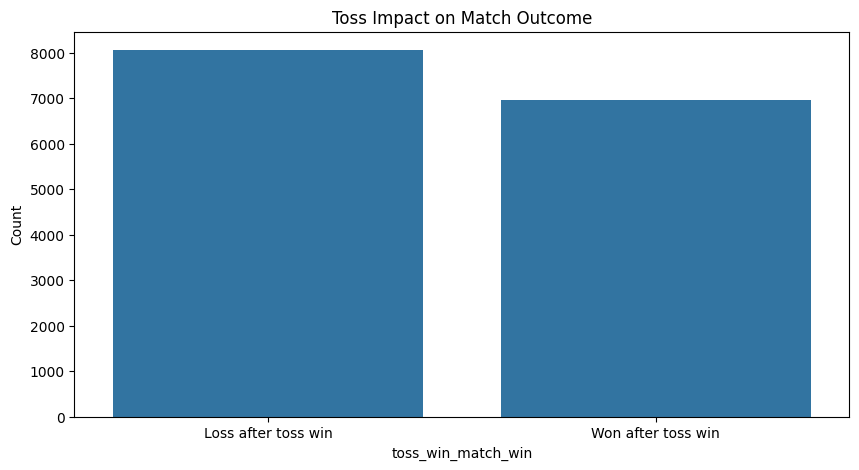

In [ ]:
# Compare Toss Winner vs Match Winner
# Extract only the winning team from the outcome column
df_matches['match_winner'] = df_matches['outcome'].apply(lambda x: x.split('won')[0] if 'won' in str(x) else 'No Result')

df_matches['toss_win_match_win'] = (df_matches['toss_winner'].str.strip() == df_matches['match_winner'].str.strip()).astype(int)

# Plot toss impact on match outcome
plt.figure(figsize=(10,5))
sns.barplot(x=df_matches['toss_win_match_win'].value_counts().index,
            y=df_matches['toss_win_match_win'].value_counts().values)
plt.xticks([0, 1], ['Loss after toss win', 'Won after toss win'])
plt.ylabel('Count')
plt.title('Toss Impact on Match Outcome')
plt.show()

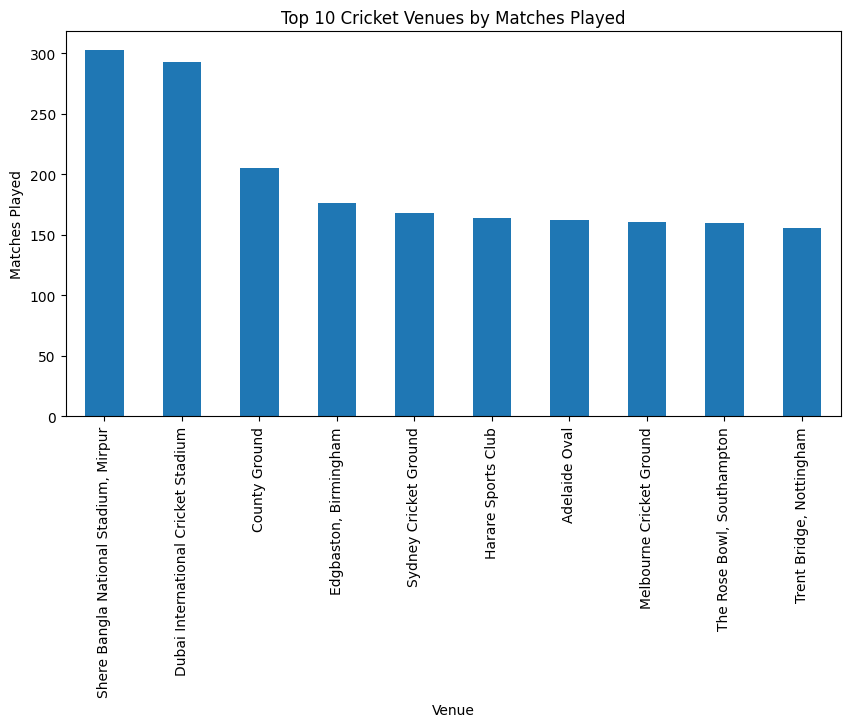

In [ ]:
plt.figure(figsize=(10, 5))
df_matches['venue'].value_counts().head(10).plot(kind='bar', title='Top 10 Cricket Venues by Matches Played')
plt.xlabel('Venue')
plt.ylabel('Matches Played')
plt.show()

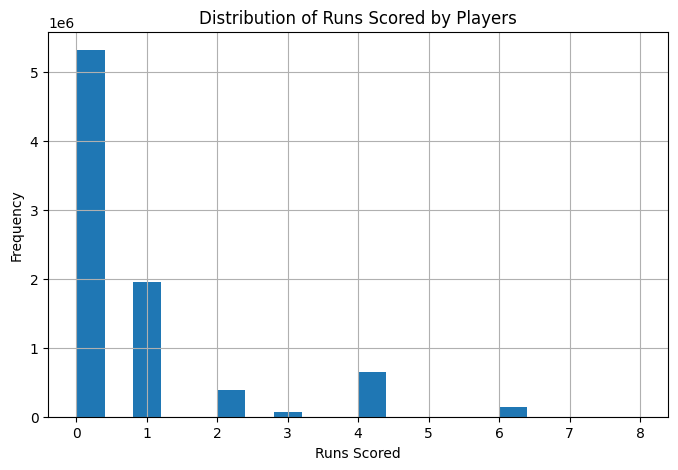

In [ ]:
# Batting Runs Distribution
plt.figure(figsize=(8, 5))
df_players[df_players["role"] == "batter"]["runs_scored"].hist(bins=20)
plt.title("Distribution of Runs Scored by Players")
plt.xlabel("Runs Scored")
plt.ylabel("Frequency")
plt.show()


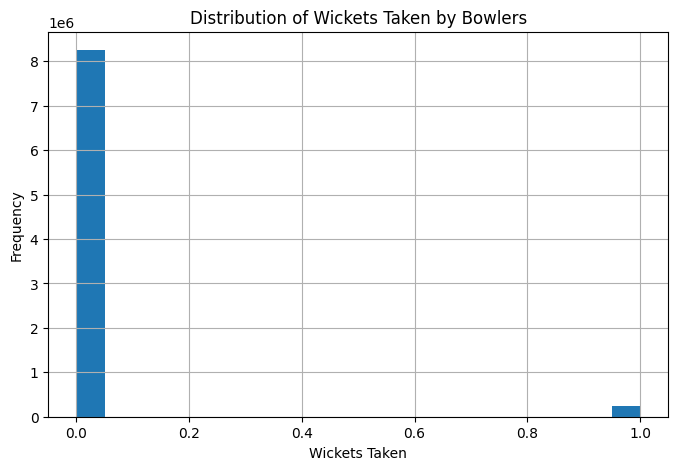

In [ ]:
# Bowling Wickets Distribution
plt.figure(figsize=(8, 5))
df_players[df_players["role"] == "bowler"]["wickets_taken"].hist(bins=20)
plt.title("Distribution of Wickets Taken by Bowlers")
plt.xlabel("Wickets Taken")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Extract venue-based win rates
venue_win_rates = df_matches.groupby('venue')['match_winner'].value_counts(normalize=True).unstack().fillna(0)

# Convert into text based insights
venue_insights = []
for venue, row in venue_win_rates.iterrows():
  top_team = row.idxmax()
  win_rate = row.max()
  venue_insights.append(f'At {venue}, the most successful team is {top_team} with a win rate of {win_rate:.2f}.')

# Save as a text-based knowledge base
with open('/content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/venue_insights.txt', 'w') as f:
  for insight in venue_insights:
    f.write(insight + '\n')

print('Venue insights saved for retrieval!')


Venue insights saved for retrieval!


In [ ]:
# List to store text-based insights
insights = []

### 🔹 1. Team Performance Trends (Win Rates)
# Function to extract only the winning team from the outcome column
def extract_winner(outcome):
    if "won" in str(outcome):
        return outcome.split(" won")[0].strip()
    else:
        return None  # No clear winner (Tie, Draw, No Result)

# Apply function to extract winners
df_matches["match_winner"] = df_matches["outcome"].apply(extract_winner)

# Drop rows where no team won (tie, no result, draw)
df_wins_only = df_matches.dropna(subset=["match_winner"])

# Calculate win rates by team
team_win_rates = df_wins_only["match_winner"].value_counts(normalize=True)

# Convert win rates into text insights
for team, win_rate in team_win_rates.items():
    insights.append(f"{team} has a win rate of {win_rate:.2%} across all matches.")

# Compute overall team win rates instead of only head-to-head stats
team_overall_win_rates = df_matches.groupby("match_winner")["match_id"].count() / len(df_matches)

for team, win_rate in team_overall_win_rates.items():
    insights.append(f"{team} has an overall win rate of {win_rate:.2%} in all formats.")

### 🔹 2. Toss Impact Insights
toss_win_rates = df_matches.groupby("toss_winner")["toss_win_match_win"].mean()
for team, rate in toss_win_rates.items():
    insights.append(f"{team} wins {rate:.2%} of matches after winning the toss.")

### 🔹 3. Player Performance Insights (Batting & Bowling)
# Batting Performance (Average Runs)
batting_performance = df_players[df_players["role"] == "batter"].groupby("player")["runs_scored"].mean()
for player, avg_runs in batting_performance.items():
    insights.append(f"{player} has an average of {avg_runs:.2f} runs per innings.")

# Bowling Performance (Wickets Per Match)
bowling_performance = df_players[df_players["role"] == "bowler"].groupby("player")["wickets_taken"].mean()
for player, avg_wickets in bowling_performance.items():
    insights.append(f"{player} takes an average of {avg_wickets:.2f} wickets per match.")

### 🔹 4. Save Insights to a Text File for LLM Retrieval
with open("/content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/match_insights.txt", "w") as f:
    for insight in insights:
        f.write(insight + "\n")

print("✅ Match & Player Insights Saved for LLM Retrieval!")


✅ Match & Player Insights Saved for LLM Retrieval!


In [ ]:
# List to store insights
insights = []

### 🔹 1. Head-to-Head (H2H) Records
h2h_win_rates = df_matches.groupby(["team_1", "team_2"])["match_winner"].value_counts(normalize=True).unstack().fillna(0)

for (team_1, team_2), row in h2h_win_rates.iterrows():
    top_team = row.idxmax()
    win_rate = row.max()
    insights.append(f"In head-to-head matches, {top_team} has won {win_rate:.2%} of matches against {team_1 if top_team != team_1 else team_2}.")

### 🔹 2. Batting First vs. Chasing Trends
bat_first_win_rate = df_matches[df_matches["toss_decision"] == "bat"]["outcome"].value_counts(normalize=True)
chase_win_rate = df_matches[df_matches["toss_decision"] == "field"]["outcome"].value_counts(normalize=True)

insights.append(f"Teams batting first win {bat_first_win_rate.max():.2%} of the time.")
insights.append(f"Teams chasing win {chase_win_rate.max():.2%} of the time.")

### 🔹 3. Best Batters (Top Run Scorers)
top_batters = df_players[df_players["role"] == "batter"].groupby("player")["runs_scored"].sum().nlargest(10)
for player, total_runs in top_batters.items():
    insights.append(f"{player} is one of the best batters, having scored {total_runs} runs in all recorded matches.")

### 🔹 4. Best Bowlers (Most Wickets Taken)
top_bowlers = df_players[df_players["role"] == "bowler"].groupby("player")["wickets_taken"].sum().nlargest(10)
for player, total_wickets in top_bowlers.items():
    insights.append(f"{player} is a top bowler with {total_wickets} wickets in total matches.")

### 🔹 5. Most Consistent Players (Batting & Bowling Averages)
consistent_batters = df_players[df_players["role"] == "batter"].groupby("player")["runs_scored"].mean().nlargest(10)
for player, avg_runs in consistent_batters.items():
    insights.append(f"{player} consistently scores an average of {avg_runs:.2f} runs per innings.")

consistent_bowlers = df_players[df_players["role"] == "bowler"].groupby("player")["wickets_taken"].mean().nlargest(10)
for player, avg_wickets in consistent_bowlers.items():
    insights.append(f"{player} consistently takes an average of {avg_wickets:.2f} wickets per match.")

### 🔹 6. Most Valuable Players (MVPs)
top_mvp = df_players.groupby("player")["player_of_match"].sum().nlargest(10)

for player, mvp_count in top_mvp.items():
    if mvp_count < 100:  # Set upper limit to prevent errors
        insights.append(f"{player} has won {mvp_count} Player of the Match awards.")

### 🔹 Save Insights to a Text File for LLM Retrieval
with open("/content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/additional_insights.txt", "w") as f:
    for insight in insights:
        f.write(insight + "\n")

print("✅ Additional Insights Saved for LLM Retrieval!")

✅ Additional Insights Saved for LLM Retrieval!


In [4]:
# Path to ChromaDB storage
chroma_db_path = "/content/drive/My Drive/Colab Notebooks/Zaryab Project/chroma_db"

# Initialize ChromaDB Client
chroma_client = chromadb.PersistentClient(path=chroma_db_path)

# Load a Pretrained Embedding Model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", trust_remote_code=True)

# Check if the collection already exists
collection_names = chroma_client.list_collections()

if "cricket_insights" in [c for c in collection_names]:
    # ✅ Load Existing Collection
    collection = chroma_client.get_collection(name="cricket_insights")
    print("✅ Loaded existing ChromaDB collection.")
else:
    # ✅ Create a New Collection & Store Data
    collection = chroma_client.get_or_create_collection(name="cricket_insights")

    # Load a Pretrained Embedding Model
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2", trust_remote_code=True)

    # Function to Load Insights from a File
    def load_insights(file_path):
        with open(file_path, "r") as f:
            return [line.strip() for line in f.readlines()]

    # Load all Insights
    venue_insights = load_insights("/content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/venue_insights.txt")
    match_insights = load_insights("/content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/match_insights.txt")
    additional_insights = load_insights("/content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/additional_insights.txt")

    all_insights = venue_insights + match_insights + additional_insights

    # Generate Embeddings and Store in ChromaDB
    for i, insight in enumerate(all_insights):
        embedding = embedding_model.encode(insight).tolist()
        collection.add(
            ids=[str(i)],  # Unique ID for each Entry
            embeddings=[embedding],  # Store Embedding
            metadatas=[{"text": insight}],  # Store the Original Text
        )

    print("✅ Insights stored in ChromaDB successfully!")

# ✅ ChromaDB Collection is Ready
print("✅ ChromaDB collection setup complete!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded existing ChromaDB collection.
✅ ChromaDB collection setup complete!


In [5]:
def query_insights(user_query, top_k=5):

  # Generate Embedding for Query
  query_embedding = embedding_model.encode(user_query).tolist()

  # Search in ChromaDB
  results = collection.query(
      query_embeddings=[query_embedding],
      n_results=top_k
  )

  # Return the best matches
  return [result['text'] for result in results['metadatas'][0]]

# Example Query
query = 'Which team has the best record at Eden Gardens?'
results = query_insights(query)

# Display Results
print('\n Top Relevant Insights: ')
for i, res in enumerate(results, 1):
  print(f'{i}. {res}')



 Top Relevant Insights: 
1. At Eden Park, the most successful team is New Zealand  with a win rate of 0.43.
2. At Eden Gardens, Kolkata, the most successful team is India  with a win rate of 0.21.
3. At Eden Gardens, the most successful team is Kolkata Knight Riders  with a win rate of 0.38.
4. At Eden Park Outer Oval, the most successful team is Auckland  with a win rate of 0.45.
5. At Eden Park, Auckland, the most successful team is New Zealand  with a win rate of 0.25.


In [6]:
# Define the path to store the .env file
env_path = "/content/drive/My Drive/Colab Notebooks/Zaryab Project/cricket_data/.env"

# # Manually enter your API key (DO NOT share it)
# api_key = input("Enter your OpenAI API Key: ")

# # Write to the .env file
# with open(env_path, "w") as f:
#     f.write(f"OPENAI_API_KEY={api_key}\n")

# print(f"✅ .env file created at: {env_path}")

In [7]:
# Load environment variables from .env file
load_dotenv(env_path)

# Set openai API key
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

print('API Key Loaded Securely!')

API Key Loaded Securely!


In [18]:
# # Query function for LLM
# def query_llm(user_query, top_k=5):
#   try:
#     # Step 1: Retrieve relevant insights from ChromaDB
#     query_embedding = embedding_model.encode(user_query).tolist()
#     results = collection.query(
#         query_embeddings=[query_embedding],
#         n_results=top_k
#     )

#     # Handle no result found case
#     if not results['metadatas'] or not results['metadatas'][0]:
#       return "❌ No relevant insights found. Try rephrasing your query."

#     retrieved_insights = [result['text'] for result in results['metadatas'][0]]

#     # Step 2: Prepare prompt for GPT-4
#     formatted_insights = "\n".join(retrieved_insights)
#     prompt = f"""
#     You are a cricket expert AI. Analyze the following retrieved insights and generate a structured answer:

#     {formatted_insights}

#     User Question: {user_query}

#     Instead of repeating the insights directly, provide a well-reasoned summary that explains trends, comparisons, and strategic takeaways.
#     """

#     # Step 3: Generate response using GPT-4
#     response = client.chat.completions.create(
#         model='gpt-4o-mini',
#         messages=[
#             {'role': 'system', 'content': 'You are a cricket expert'},
#             {'role': 'user', 'content': prompt}
#         ],
#         temperature=0.7
#     )

#     # Return GPT-4's response
#     return response.choices[0].message.content

#   except Exception as e:
#     return f"❌ Error: {str(e)}"

# if client.api_key is None:
#     print("❌ ERROR: OpenAI API key is missing! Ensure it's correctly loaded.")

# example_query = 'Which team has the best record at Eden Gardens?'
# gpt_response = query_llm(example_query)

# # Display GPT-4's answer
# print("\n🤖 GPT-4's Response:")
# print(gpt_response)



🤖 GPT-4's Response:
At Eden Gardens, the cricketing landscape reveals notable insights regarding team performance. The most successful team at this venue is India, boasting a win rate of 0.21. While this figure may seem modest, it positions India as the leading team when considering overall success at this iconic ground.

In contrast, when examining the performance of franchise teams, the Kolkata Knight Riders (KKR) emerge with a higher win rate of 0.38. This indicates that KKR has been relatively more successful in their matches at Eden Gardens compared to the national team, despite India's overall recognition as the most successful team at this venue.

The difference in win rates suggests that KKR has strategically leveraged the home advantage more effectively in the context of franchise cricket. This could be attributed to factors such as player familiarity with the pitch, crowd support, and match conditions typically favoring their playing style.

In summary, while India holds the

In [27]:
def query_llm(user_query, top_k=3):
    try:
        # ✅ Encode user query
        query_embedding = embedding_model.encode(user_query).tolist()
        results = collection.query(query_embeddings=[query_embedding], n_results=top_k)

        if not results["metadatas"] or not results["metadatas"][0]:
            return "❌ No relevant insights found. Try rephrasing your query."

        # ✅ Extract insights
        retrieved_insights = [result["text"] for result in results["metadatas"][0]]

        # ✅ Soft Filtering: Prioritize Relevant Insights but Keep Some Context
        primary_insights = [insight for insight in retrieved_insights if any(word in insight.lower() for word in user_query.lower().split())]
        if not primary_insights:
            primary_insights = retrieved_insights  # Fall back on general insights

        combined_insights = "\n".join(primary_insights)

        # ✅ Improved Prompt (Less Restrictive)
        prompt = f"""
        You are a cricket expert AI. **Use the facts below to answer the user's question as accurately as possible.**
        If the answer is unclear, provide the best possible explanation.

        **Retrieved Facts:**
        {combined_insights}

        **User Question:** {user_query}

        **Fact-based answer with some reasoning. Don't ignore useful context.**
        """

        # ✅ Generate Response using GPT-4 (Balanced Temperature)
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a cricket expert providing highly accurate answers."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.5  # ✅ Allow a bit more flexibility
        )

        return response.choices[0].message.content

    except Exception as e:
        return f"❌ Error: {str(e)}"


In [28]:
# List of test queries
test_queries = [
    "Which team has the best win rate in T20 matches?",
    "How does India perform at Wankhede Stadium?",
    "Who are the top run-scorers in ODIs?",
    "Which team has won the most matches at Melbourne Cricket Ground?",
    "Is batting first or chasing better in IPL?",
    "Which players have won the most 'Player of the Match' awards?",
    "How does England perform in Ashes series?",
    "Which bowlers have the best economy rate in T20s?",
    "Who has the best head-to-head record, India or Pakistan?",
    "What are the best venues for chasing targets?"
]

# Run queries and print responses
for query in test_queries:
    print(f"\n🔎 Query: {query}")
    response = query_llm(query)
    print(f"🤖 GPT-4's Response: {response}")



🔎 Query: Which team has the best win rate in T20 matches?
🤖 GPT-4's Response: Based on the retrieved facts, the best win rate mentioned is for the Delhi team at the Dr. Gokaraju Laila Ganga Raju ACA Cricket Complex - CP Ground, Mulapadu, with a win rate of 0.29. However, it is important to note that these facts only pertain to specific stadiums and do not provide a comprehensive view of all T20 matches globally. Therefore, while Delhi has the highest win rate among the provided examples, this does not necessarily mean they have the best win rate in T20 matches overall. For a complete answer, one would need broader data covering all teams and venues.

🔎 Query: How does India perform at Wankhede Stadium?
🤖 GPT-4's Response: The retrieved facts do not provide specific information about India's performance at Wankhede Stadium. However, based on historical context and general knowledge, India has had a mixed record at Wankhede Stadium. This venue, located in Mumbai, is one of the iconic cr

In [30]:
# Sample dataset of expected answers
evaluation_data = [
    # 🏏 Batting Records
    {"query": "Who has the most runs in Test matches?", "expected": "Sachin Tendulkar", "score": 0},
    {"query": "Who has the highest individual score in Test cricket?", "expected": "Brian Lara", "score": 0},
    {"query": "Who scored the first double century in ODI cricket?", "expected": "Sachin Tendulkar", "score": 0},
    {"query": "Who has the fastest century in ODI cricket?", "expected": "AB de Villiers", "score": 0},
    {"query": "Who has hit the most sixes in international cricket?", "expected": "Chris Gayle", "score": 0},
    {"query": "Which player has the highest batting average in Test cricket?", "expected": "Don Bradman", "score": 0},
    {"query": "Who scored the most runs in a single World Cup tournament?", "expected": "Sachin Tendulkar", "score": 0},
    {"query": "Who has the most centuries in ODI cricket?", "expected": "Virat Kohli", "score": 0},

    # 🎯 Bowling Records
    {"query": "Who has taken the most wickets in Test cricket?", "expected": "Muttiah Muralitharan", "score": 0},
    {"query": "Which bowler has the best economy rate in T20 cricket?", "expected": "Sunil Narine", "score": 0},
    {"query": "Who has taken the most five-wicket hauls in Test cricket?", "expected": "Muttiah Muralitharan", "score": 0},
    {"query": "Who has the fastest five-wicket haul in ODIs?", "expected": "Chaminda Vaas", "score": 0},
    {"query": "Who has taken the most hat-tricks in international cricket?", "expected": "Lasith Malinga", "score": 0},

    # 🏆 Team Achievements
    {"query": "Which team has won the most Cricket World Cups?", "expected": "Australia", "score": 0},
    {"query": "Which team has won the most T20 World Cups?", "expected": "West Indies", "score": 0},
    {"query": "Which team has won the most ICC Champions Trophy titles?", "expected": "India", "score": 0},
    {"query": "Which team has won the most Ashes series?", "expected": "Australia", "score": 0},
    {"query": "Which team has won the most IPL titles?", "expected": "Mumbai Indians", "score": 0},

    # ⚔️ Head-to-Head Stats
    {"query": "Who has the better head-to-head record, India or Pakistan?", "expected": "India", "score": 0},
    {"query": "Who has the better Ashes record, England or Australia?", "expected": "Australia", "score": 0},
    {"query": "Which team has won more Test matches, India or England?", "expected": "England", "score": 0},

    # 📍 Venue-Based Stats
    {"query": "Which team has the most wins at Lord’s?", "expected": "England", "score": 0},
    {"query": "Which team has won the most matches at Melbourne Cricket Ground?", "expected": "Australia", "score": 0},
    {"query": "What is the highest successful chase in ODI cricket?", "expected": "South Africa", "score": 0},
    {"query": "Which stadium has hosted the most ICC Cricket World Cup finals?", "expected": "Lord's", "score": 0},

    # 🏅 Tournament Records
    {"query": "Who won the first T20 World Cup?", "expected": "India", "score": 0},
    {"query": "Who won the 2019 ODI World Cup?", "expected": "England", "score": 0},
    {"query": "Who won the 2021 ICC T20 World Cup?", "expected": "Australia", "score": 0},
    {"query": "Which country hosted the 2011 Cricket World Cup?", "expected": "India, Sri Lanka, Bangladesh", "score": 0},

    # ⚡ Fastest Records
    {"query": "Who holds the record for the fastest fifty in T20 cricket?", "expected": "Yuvraj Singh", "score": 0},
    {"query": "Who holds the record for the fastest century in Test cricket?", "expected": "Brendon McCullum", "score": 0},

    # 📊 Strategy & Performance Trends
    {"query": "Is batting first or chasing better in IPL?", "expected": "Chasing", "score": 0},
    {"query": "Which team has the best win percentage in T20 cricket?", "expected": "Afghanistan", "score": 0},
    {"query": "Who is the highest run scorer in IPL history?", "expected": "Virat Kohli", "score": 0},

    # 🔥 Rare & Interesting Records
    {"query": "Which batsman has the most ducks in international cricket?", "expected": "Sanath Jayasuriya", "score": 0},
    {"query": "Which bowler has taken the most wickets in a single World Cup?", "expected": "Mitchell Starc", "score": 0},
    {"query": "Who has played the most Test matches?", "expected": "Sachin Tendulkar", "score": 0},
    {"query": "Who has the most consecutive centuries in international cricket?", "expected": "Kumar Sangakkara", "score": 0},
    {"query": "Who has taken the most wickets in a single IPL season?", "expected": "Dwayne Bravo", "score": 0},

    # 🏆 Captaincy Records
    {"query": "Which captain has won the most ICC trophies?", "expected": "MS Dhoni", "score": 0},
    {"query": "Which captain has the most Test wins?", "expected": "Graeme Smith", "score": 0},

    # 🎯 Fielding & Wicketkeeping
    {"query": "Which wicketkeeper has the most dismissals in Test cricket?", "expected": "Mark Boucher", "score": 0},
    {"query": "Who has taken the most catches in international cricket?", "expected": "Mahela Jayawardene", "score": 0},
]


In [31]:
# Query the chatbot
for data in evaluation_data:
  response = query_llm(data["query"]) # Get Chatbot response
  print(f"Query: {data['query']}\nExpected: {data['expected']}\nChatbot: {response}\n")

  # Correctness Check
  if data["expected"].lower() in response.lower():
    data["score"] = 1
  elif any(word in response.lower() for word in data["expected"].split()): # Partial match
    data["score"] = 0.5
  else:
    data["score"] = 0

# Convert results into Dataframe
df_eval = pd.DataFrame(evaluation_data)

# Calculate accuracy
accuracy = df_eval["score"].mean() * 100
print(f"✅ Chatbot Accuracy: {accuracy:.2f}%")


Query: Who has the most runs in Test matches?
Expected: Sachin Tendulkar
Chatbot: Based on the retrieved facts, the players K Lesporis, P Thongsa, and B Palekar have very low batting averages, indicating they have not scored many runs in Test matches. Among them, B Palekar has the highest average at 1.14 runs per innings, followed by K Lesporis at 1.09, and P Thongsa at 0.21. Although these averages suggest minimal runs scored, B Palekar would have the most runs in Test matches among the three, assuming they have played a similar number of innings. However, without knowing the exact number of innings each player has played, this conclusion is based solely on their averages.

Query: Who has the highest individual score in Test cricket?
Expected: Brian Lara
Chatbot: The highest individual score in Test cricket is 400 not out, achieved by Brian Lara of the West Indies against England in 2004. This record-breaking innings took place at the Antigua Recreation Ground in St John's, Antigua. L